In [1]:
# Some standard imports
import io,os
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [2]:
os.makedirs("./pytorch/superres")

### Image Preprocess + Post-Process

In [3]:
from PIL import Image
import requests
from io import BytesIO

url = "https://pytorch.org/tutorials/_images/cat_224x224.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
print(np.asarray(img).shape); img

img.save("./pytorch/superres/cat224x224.jpg")

(224, 224, 3)


In [4]:
h,w = img.size

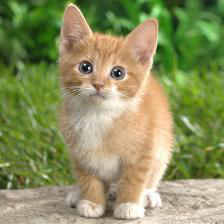

In [5]:
img

### without superres

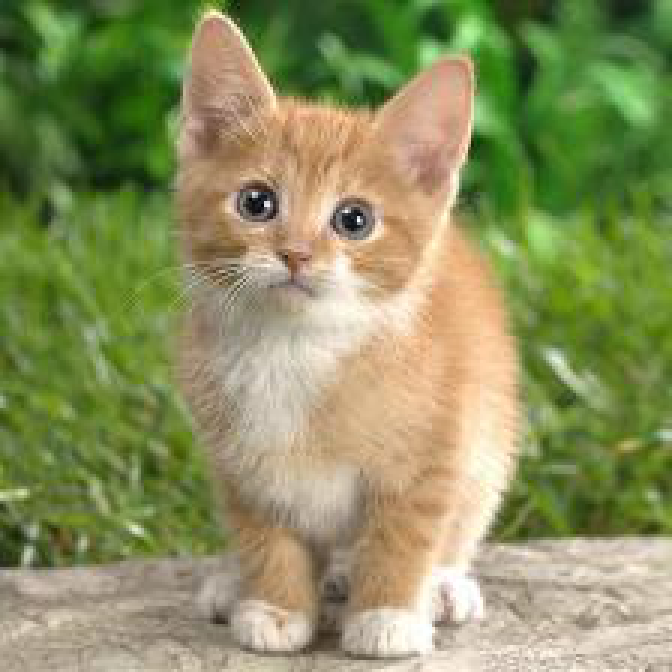

In [6]:
img.resize((h*3, w*3))

### preprocess and postprocess

In [7]:
from torchvision.transforms import ToTensor
def img2tensor(img_fn):
    "reading image from filename and converting to pytorch tensor"
    img = Image.open(img_fn).convert('YCbCr')
    y, cb, cr = img.split()
    img_to_tensor = ToTensor()
    return img_to_tensor(y).view(1, -1, y.size[1], y.size[0]), (y, cb, cr)

In [8]:
input_tensor, img_channels = img2tensor('./pytorch/superres/cat224x224.jpg')

In [11]:
input_tensor.shape, img_channels

(torch.Size([1, 1, 224, 224]),
 (<PIL.Image.Image image mode=L size=224x224 at 0x7F43A4140E48>,
  <PIL.Image.Image image mode=L size=224x224 at 0x7F43A4140358>,
  <PIL.Image.Image image mode=L size=224x224 at 0x7F43A41405C0>))

In [12]:
y, cb, cr = img_channels

In [13]:
import pdb
def postprocess(out, cb, cr):
#     pdb.set_trace()
    "post-process to get superres final image given out image, cb, cr"
    if isinstance(out, torch.Tensor):
        out = out.cpu()
        out_img_y = out[0].detach().numpy()
    elif isinstance(out, np.ndarray):
        out_img_y = out[0]
        
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    return out_img

### model

In [14]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

In [15]:
# # dummy supperres model - which gives correct results both on pytorch and caffe2
# class SuperResolutionNet(nn.Module):
#     def __init__(self, upscale_factor, inplace=False):
#         super(SuperResolutionNet, self).__init__()

#         self.relu = nn.ReLU(inplace=inplace)
#         self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
#         self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
#         self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
#         self.conv4 = nn.Conv2d(32, 1, (3, 3), (1, 1), (1, 1))
#         self.pixel_shuffle = nn.Upsample(scale_factor=upscale_factor, mode='nearest')

#         self._initialize_weights()

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))
#         x = self.relu(self.conv3(x))
#         x = self.pixel_shuffle(self.conv4(x))
#         return x

#     def _initialize_weights(self):
#         init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
#         init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
#         init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
#         init.orthogonal_(self.conv4.weight)

# # Create the super-resolution model by using the above model definition.
# torch_model = SuperResolutionNet(upscale_factor=3)

In [16]:
torch_model

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [17]:
# #This is useful for implementing efficient sub-pixel convolution with a stride of 1/r.a
# input = torch.rand(10, 16, 8, 8)
# pixel_shuffle = torch.nn.PixelShuffle(upscale_factor=2)
# pixel_shuffle(input).shape

### Load Pretrained Model

In [18]:
# Load pretrained model weights
from warnings import warn
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
try:
    map_location = lambda storage, loc: storage
    if torch.cuda.is_available():
        map_location = None
    torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))
    print("pretrained weights loaded")
except:
    warn("Can't load pretrained weights")
    
# set the train mode to false since we will only run the forward pass.
torch_model.eval();

pretrained weights loaded


### PyTorch Test

In [19]:
torch_out = torch_model(input_tensor)

In [20]:
torch_out

tensor([[[[0.1595, 0.1839, 0.1828,  ..., 0.4952, 0.4600, 0.4099],
          [0.1789, 0.2720, 0.2703,  ..., 0.6387, 0.6096, 0.4684],
          [0.2226, 0.2698, 0.2636,  ..., 0.6488, 0.6308, 0.4745],
          ...,
          [0.5924, 0.6671, 0.6872,  ..., 0.7170, 0.7296, 0.5932],
          [0.5416, 0.6099, 0.6267,  ..., 0.6862, 0.6902, 0.5797],
          [0.4989, 0.5080, 0.5032,  ..., 0.5376, 0.5493, 0.5179]]]],
       grad_fn=<UnsafeViewBackward>)

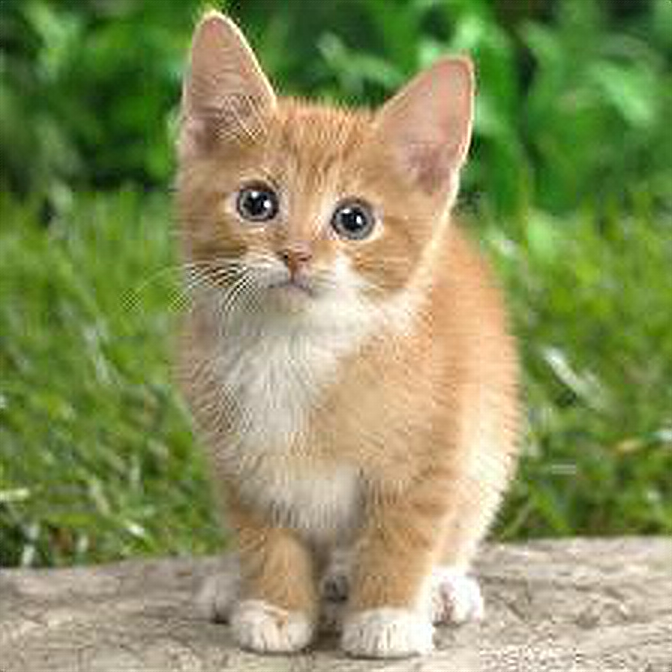

In [21]:
final_img = postprocess(torch_out, cb, cr)
final_img

### Convert Model to Onnx

In [22]:
# Export the model
torch_out = torch.onnx._export(torch_model,             # model being run
                               input_tensor,                       # model input (or a tuple for multiple inputs)
                               "./pytorch/superres/super_resolution.onnx", # where to save the model (can be a file or file-like object)
                               export_params=True)      # store the trained parameter weights inside the model file
torch_out.detach_();

In [23]:
torch_out

tensor([[[[0.1595, 0.1839, 0.1828,  ..., 0.4952, 0.4600, 0.4099],
          [0.1789, 0.2720, 0.2703,  ..., 0.6387, 0.6096, 0.4684],
          [0.2226, 0.2698, 0.2636,  ..., 0.6488, 0.6308, 0.4745],
          ...,
          [0.5924, 0.6671, 0.6872,  ..., 0.7170, 0.7296, 0.5932],
          [0.5416, 0.6099, 0.6267,  ..., 0.6862, 0.6902, 0.5797],
          [0.4989, 0.5080, 0.5032,  ..., 0.5376, 0.5493, 0.5179]]]])

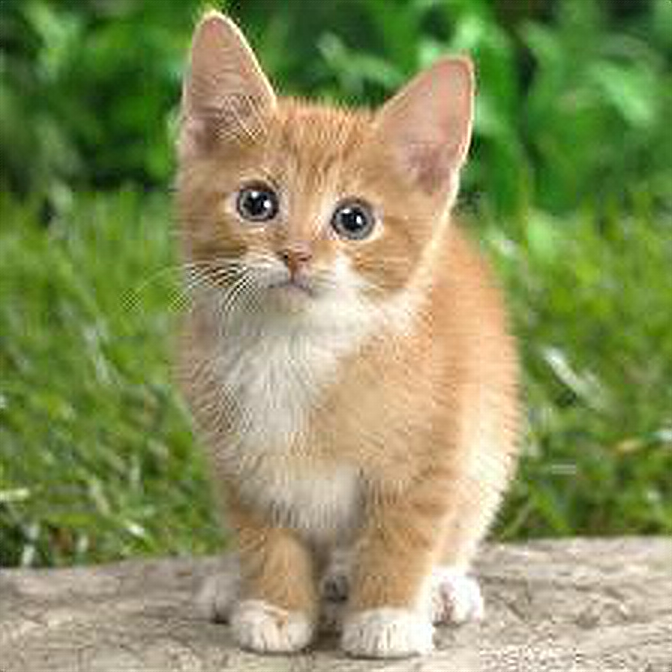

In [24]:
final_img = postprocess(torch_out, cb, cr)
final_img

### Caffe2 Test

In [29]:
import onnx
import caffe2.python.onnx.backend as onnx_caffe2_backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object
onnx_model = onnx.load("./pytorch/superres/super_resolution.onnx")

prepared_backend = onnx_caffe2_backend.prepare(onnx_model, device="CUDA:0")

W = {onnx_model.graph.input[0].name: input_tensor.data.numpy().astype(np.float32)}
# Run the Caffe2 net:
caffe2_out = prepared_backend.run(W)[0]

# Verify the numerical correctness upto 3 decimal places
try:
    np.testing.assert_almost_equal(torch_out.div(255).data.cpu().numpy(), caffe2_out, decimal=2)
except: 
    print('Test failed, PyTorch and Caffe2 outputs are different')

CUDA operators do not support 64-bit doubles, please use arr.astype(np.float32) or np.int32 for ints. Blob: 0 type: float64


Test failed, PyTorch and Caffe2 outputs are different


In [30]:
caffe2_out

array([[[[0.15948252, 0.1845647 , 0.1912275 , ..., 0.5260383 ,
          0.5285196 , 0.40989673],
         [0.19390629, 0.18422325, 0.19115487, ..., 0.5406729 ,
          0.55481356, 0.54562473],
         [0.19336525, 0.17603539, 0.18609332, ..., 0.5261741 ,
          0.5385075 , 0.5485972 ],
         ...,
         [0.64958894, 0.6867803 , 0.6660947 , ..., 0.7003092 ,
          0.6284961 , 0.56166244],
         [0.6206756 , 0.6564043 , 0.6062353 , ..., 0.86413246,
          0.7400922 , 0.5905412 ],
         [0.49894184, 0.63069445, 0.6524436 , ..., 0.7570608 ,
          0.65433735, 0.5178513 ]]]], dtype=float32)

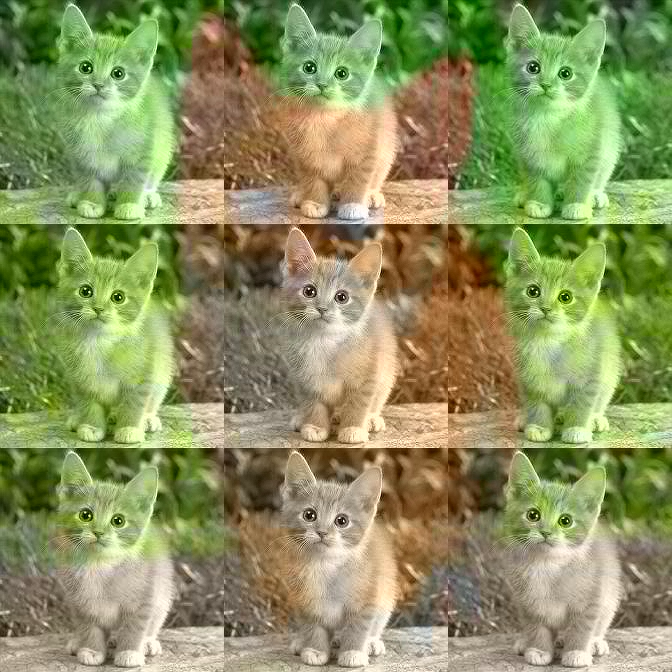

In [31]:
# Probably due to PixelShuffle() implementation error
postprocess(caffe2_out, cb, cr)

### Test with mobile

init_net has the model parameters and the model input embedded in it and predict_net will be used to guide the init_net execution at run-time. In this tutorial, we will use the init_net and predict_net generated above and run them in both normal Caffe2 backend and mobile and verify that the output high-resolution cat image produced in both runs is the same.

In [32]:
# extract the workspace and the model proto from the internal representation
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net

# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('./pytorch/superres/init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('./pytorch/superres/predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

In [33]:
# Some standard imports
from caffe2.proto import caffe2_pb2
from caffe2.python import core, net_drawer, net_printer, visualize, workspace, utils

import numpy as np
import os
import subprocess
from PIL import Image
from matplotlib import pyplot
from skimage import io, transform

net_drawer will not run correctly. Please install the correct dependencies.


In [369]:
# PixelShuffle Implemented as following
# torch-jit-export_predict.Reshape(['15', '16'], ['17', 'OC2_DUMMY_0'])
# torch-jit-export_predict.Transpose(['17'], ['18'], axes=[0, 1, 4, 2, 5, 3])
# torch-jit-export_predict.Reshape(['18', '19'], ['20', 'OC2_DUMMY_1'])

In [370]:
# Let's run the mobile nets that we generated above so that caffe2 workspace is properly initialized
workspace.RunNetOnce(init_net)
workspace.RunNetOnce(predict_net)

# Caffe2 has a nice net_printer to be able to inspect what the net looks like and identify
# what our input and output blob names are.
print(net_printer.to_string(predict_net))

torch-jit-export_predict = core.Net('torch-jit-export_predict')
torch-jit-export_predict.Conv(['0', '1', '2'], ['9'], strides=[1, 1], pads=[2, 2, 2, 2], kernels=[5, 5], group=1, dilations=[1, 1])
torch-jit-export_predict.Relu(['9'], ['10'])
torch-jit-export_predict.Conv(['10', '3', '4'], ['11'], strides=[1, 1], pads=[1, 1, 1, 1], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.Relu(['11'], ['12'])
torch-jit-export_predict.Conv(['12', '5', '6'], ['13'], strides=[1, 1], pads=[1, 1, 1, 1], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.Relu(['13'], ['14'])
torch-jit-export_predict.Conv(['14', '7', '8'], ['15'], strides=[1, 1], pads=[1, 1, 1, 1], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.Reshape(['15', '16'], ['17', 'OC2_DUMMY_0'])
torch-jit-export_predict.Transpose(['17'], ['18'], axes=[0, 1, 4, 2, 5, 3])
torch-jit-export_predict.Reshape(['18', '19'], ['20', 'OC2_DUMMY_1'])


In [371]:
# Now, let's also pass in the resized cat image for processing by the model.
workspace.FeedBlob("0", input_tensor.data.numpy().astype(np.float32))

# run the predict_net to get the model output
workspace.RunNetOnce(predict_net)

# Now let's get the model output blob
img_out = workspace.FetchBlob("20")

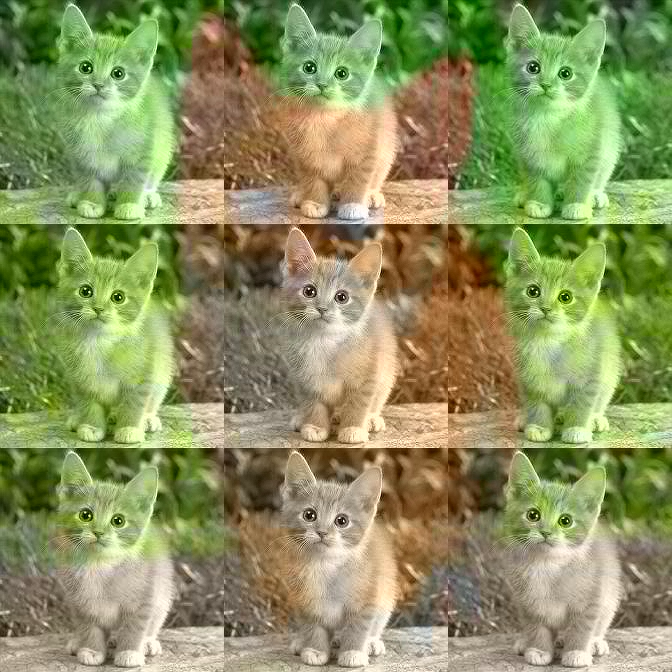

In [374]:
postprocess(img_out, cb, cr)

### todo: Test with Android Emulator

https://developer.android.com/studio/intro/update#sdk-manager

In [ ]:
#!sudo apt-get install android-tools-adb android-tools-fastboot

In [375]:
# let's first push a bunch of stuff to adb, specify the path for the binary
CAFFE2_MOBILE_BINARY = ('./pytorch/superres/speed_benchmark.cc')

In [376]:
# we had saved our init_net and proto_net in steps above, we use them now.
# Push the binary and the model protos
os.system('adb push ' + CAFFE2_MOBILE_BINARY + ' /tmp/')
os.system('adb push ./pytorch/superres/init_net.pb /tmp')
os.system('adb push ./pytorch/superres/predict_net.pb /tmp')

256

In [377]:
# Let's serialize the input image blob to a blob proto and then send it to mobile for execution.
with open("./pytorch/superres/input.blobproto", "wb") as fid:
    fid.write(workspace.SerializeBlob("9"))

In [378]:
# push the input image blob to adb
os.system('adb push ./pytorch/superres/input.blobproto /tmp/')

256

In [ ]:
# Now we run the net on mobile, look at the speed_benchmark --help for what various options mean
os.system(
    'adb shell /data/local/tmp/speed_benchmark '                     # binary to execute
    '--init_net=/data/local/tmp/super_resolution_mobile_init.pb '    # mobile init_net
    '--net=/data/local/tmp/super_resolution_mobile_predict.pb '      # mobile predict_net
    '--input=9 '                                                     # name of our input image blob
    '--input_file=/data/local/tmp/input.blobproto '                  # serialized input image
    '--output_folder=/data/local/tmp '                               # destination folder for saving mobile output
    '--output=27,9 '                                                 # output blobs we are interested in
    '--iter=1 '                                                      # number of net iterations to execute
    '--caffe2_log_level=0 '
)

# get the model output from adb and save to a file
os.system('adb pull /data/local/tmp/27 ./output.blobproto')


# We can recover the output content and post-process the model using same steps as we followed earlier
blob_proto = caffe2_pb2.BlobProto()
blob_proto.ParseFromString(open('./output.blobproto').read())
img_out = utils.Caffe2TensorToNumpyArray(blob_proto.tensor)
img_out_y = Image.fromarray(np.uint8((img_out[0,0]).clip(0, 255)), mode='L')
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")
final_img.save("./_static/img/cat_superres_mobile.jpg")

### End Notes

- `PixelShuffle()`op doesn't seem to give consistent results in pytorch and caffe2 backend.
- Issue for `PixelShuffle()` https://github.com/pytorch/pytorch/issues/13836